In [13]:
import sys
import os
sys.path.append(os.path.abspath('../..')) # include top level package in python path

In [14]:
import torch
from comparison.examples.vae_mnist import VAE_MNIST
from comparison.loss import ELBO, IWAE_loss, CIWAE_loss, PIWAE_loss
from comparison.metric import IWAE_64, log_px
from comparison.metric import IWAE_metric, CIWAE_metric, PIWAE_metric
from tqdm.notebook import tqdm
import csv

In [15]:
# Change device as needed. 
# CPU is supported on all machines, CUDA for specific GPUs.

# device = 'cpu'
device = 'cuda'

import time
model_dir = './_modeldata/'
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)

20220404-013107


In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dataset = datasets.MNIST('./_mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

test_dataset = datasets.MNIST('./_mnist', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# We set a low batch_size for sampling IWAE with K=5000
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [17]:
def train_epoch(model, optims, dataloader, loss_function, label):
    model.train()
    ls = 0;
    for imgs, _ in tqdm(dataloader, desc="Training Epoch №%s" % label, leave=False):
        imgs = imgs.view(-1, 28*28).to(device)
        losses = loss_function(model, imgs)
        #convert single values to tuple for uniformity
        if type(losses) is not tuple:
            losses = losses,
        
        for optim, loss in zip(optims, losses):
            loss = -loss
            optim.zero_grad()
            loss.backward()
            optim.step()
            ls += loss.item()


In [28]:
# this is kinda slow and if someone who's better at pytorch
# than me fancies speeding it up would be very helpful

def test(model, test_loader, label):
    with torch.no_grad():
        #evaluate metrics
        test_scores = {
            "IWAE-64": 0.0,
            "log(px)": 0.0,
            "-KL"    : 0.0
        }

        for imgs, _ in tqdm(test_loader, desc="Test Epoch №%s" % label, leave=False):
            imgs = imgs.view(-1, 28*28).to(device)            
            IWAE_64_loss = IWAE_64(model, imgs)
            logpx_loss = log_px(model, imgs)
            negKL_loss = logpx_loss - IWAE_64_loss
            
            # I can't work out best practice for summing these tensors
            # expecially with cuda maybe it's faster to append them all to a 
            # list and then sum that but idk
            test_scores["IWAE-64"] += IWAE_64_loss.sum().item()
            test_scores["log(px)"] += logpx_loss.sum().item()
            test_scores["-KL"] += negKL_loss.sum().item()
        
        N = len(test_loader.dataset)
        test_scores["IWAE-64"] /= N
        test_scores["log(px)"] /= N
        test_scores["-KL"] /= N
        
        return test_scores
        

In [27]:
def write_model_and_results(model, test_metrics, loc, name):
    torch.save(model.state_dict(), loc + "_model_"+name+"_" )
    
    with open(loc+'_results_'+name+'.csv','w') as outfile:   
        writer = csv.writer(outfile)
        writer.writerow(test_metrics.keys())
        writer.writerows(zip(*test_metrics.values()))


def train_and_evaluate(model, optims, train_loader, test_loader, loss_function, no_epochs=3, epochs_per_sample = 25, backup_loc=""):    
    test_metrics = {
        "epoch"  : [],
        "IWAE-64": [],
        "log(px)": [],
        "-KL"    : []
    }

    for epoch in range(1, no_epochs + 1):
        train_epoch(model, optims, train_loader, loss_function, epoch)
        if(epoch % epochs_per_sample == 1 or epoch == no_epochs):
            test_scores = test(model, test_loader, epoch)

            test_metrics["epoch"].append(epoch)
            test_metrics["IWAE-64"].append(test_scores["IWAE-64"])
            test_metrics["log(px)"].append(test_scores["log(px)"])
            test_metrics["-KL"].append(test_scores["-KL"])
        if(epoch % 100 == 1 and backup_loc != ""):
            write_model_and_results(model, test_metrics, backup_loc, "epoch"+str(epoch))

    return test_metrics

In [20]:
def eval_discard(loss_fn, M=1, K=1):
    return lambda model, xs: loss_fn(model(xs, M, K))

class LossTest:
    
    def __init__(self, name, loss_fn, optims, no_epochs, epochs_per_sample, no_runs = 1):
        self.name = name
        self.loss_fn = loss_fn
        self.optims = optims
        self.no_epochs = no_epochs
        self.epochs_per_sample = epochs_per_sample
        self.no_runs = no_runs

model = VAE_MNIST().to(device)
lr=1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)
inf_optim = torch.optim.Adam(model.encode_params(), lr=lr)
gen_optim = torch.optim.Adam(model.decode_params(), lr=lr)

fig5_tests = [
    LossTest("IWAE", eval_discard(IWAE_loss, M=1, K=64), [optim], 2000, 25, 1),
    LossTest("CIWAE_5", eval_discard(CIWAE_loss, M=1, K=64), [optim], 2000, 25, 1),
    LossTest("PIWAE8_8", eval_discard(PIWAE_loss, M=8, K=8), [inf_optim, gen_optim], 2000, 25, 1),
    LossTest("MIWAE8_8", eval_discard(IWAE_loss, M=8, K=8), [optim], 2000, 25, 1),
    LossTest("VAE", eval_discard(IWAE_loss, M=64, K=1), [optim], 2000, 25, 1)
]        


#iwae64_results = train_and_evaluate(model, [optim], train_loader, test_loader, iwae64, no_epochs=1)
#iwae05_results = train_and_evaluate(model, [optim], train_loader, test_loader, ciwae05, no_epochs=5)

    

In [24]:

torch.save(model.state_dict(), model_dir + timestr + "_empty_model")

for t in fig5_tests:
    print("Training ", t.name)
    for run in range(1, t.no_runs+1):
        print("Run ", run)
        
        model.load_state_dict(torch.load(model_dir + timestr + "_empty_model"))
        
        loc = model_dir + timestr + t.name + "_run" + str(run) 
        test_results = train_and_evaluate(model, t.optims, train_loader, test_loader, t.loss_fn, t.no_epochs, t.epochs_per_sample, loc)
        
        write_model_and_results(model, test_results, loc, "final")
        

Training  IWAE
Run  1


Training Epoch №1:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №2:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №3:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №4:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №5:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №6:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №7:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №8:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №9:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №10:   0%|          | 0/469 [00:00<?, ?it/s]

Test Epoch №10:   0%|          | 0/2500 [00:00<?, ?it/s]

{'IWAE-64': 167.80949946899415, 'log(px)': 167.8139242248535, '-KL': 0.004424755859375}


Training Epoch №11:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №12:   0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from comparison.plot import plot_smoothed

In [ ]:
plot_smoothed(-losses, sigma=10, fit_sigma=True)

In [ ]:
def compute_ess(model, T=100):
    effective_sample_sizes = []

    for imgs, _ in test_loader:
        with torch.no_grad():
            imgs = imgs.view(-1, 28*28).to(device)
            esss = sample_ess(model, imgs, T=100)

            for ess in list(esss):
                effective_sample_sizes.append(ess.item())
    return effective_sample_sizes

effective_sample_sizes = compute_ess(model)
    

In [ ]:
import matplotlib.pyplot as plt

# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot([effective_sample_sizes, [1e-2], [2e-2]])
plt.ylim(0,8e-2)
plt.show()

  0%|          | 0/2500 [00:00<?, ?it/s]

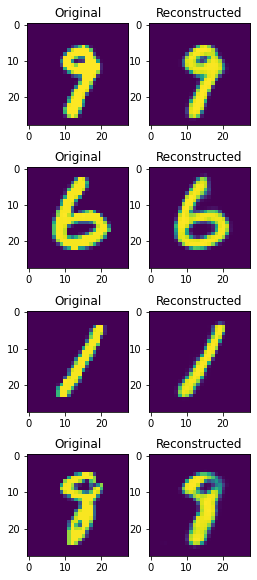

In [26]:
# test_results = train_and_evaluate(model, [optim], train_loader, test_loader, eval_discard(IWAE_loss, M=1, K=64), 6, 10, model_dir+"test")
 
model.load_state_dict(torch.load(model_dir+'20220404-013107IWAE_run1_model_epoch11_'))


import matplotlib.pyplot as plt

plt.figure(figsize=(4,26))

for imgs, _ in tqdm(test_loader):
    for i in range(imgs.shape[0]):
        if i >= 10:
            break
        img = imgs[i].view(28 * 28).to(device)
        recon = model.reconstruct(img)
        ax = plt.subplot(10, 2, 2 * i + 1)
        ax.imshow(img.view(28, 28).clone().detach().cpu())
        plt.title("Original")
        ax = plt.subplot(10, 2, 2 * i + 2)
        ax.imshow(recon.view(28, 28).clone().detach().cpu())
        plt.title("Reconstructed")
    break
plt.show()